基于密度图，以逐像素回归的方式实现人群数量预测

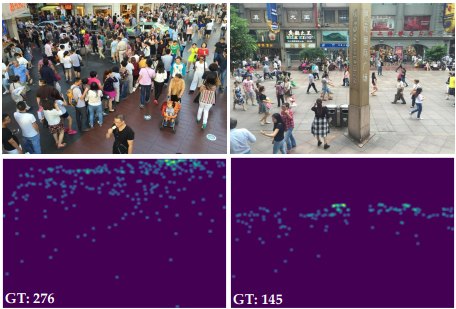

In [1]:
import os
import random

import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.transforms import Compose, ToTensor, Normalize, ToPILImage
from PIL import Image

from utils import OwnCompose, RandomCrop, RandomHorizontallyFlip, LabelNormalize, DeNormalize, initialize_weights

/home/ma-user/anaconda3/envs/PyTorch-1.11.0/lib/python3.7/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 
  warn(f"Failed to load image Python extension: {e}")


In [2]:
class SHHB(Dataset):
    def __init__(self, data_path, mode='train', main_transform=None, img_transform=None, gt_transform=None):
        self.img_path = data_path + '/' + mode + '_data/img'
        self.gt_path = data_path + '/' + mode + '_data/den'
        self.data_files = [filename for filename in os.listdir(self.img_path) \
                           if os.path.isfile(os.path.join(self.img_path,filename))]
        self.num_samples = len(self.data_files) 
        self.main_transform=main_transform  
        self.img_transform = img_transform
        self.gt_transform = gt_transform     
    
    def __getitem__(self, index):
        fname = self.data_files[index]
        img, den = self._read_image_and_gt(fname)
        if self.main_transform is not None:
            img, den = self.main_transform(img, den) 
        if self.img_transform is not None:
            img = self.img_transform(img)         
        if self.gt_transform is not None:
            den = self.gt_transform(den)               
        return img, den

    def __len__(self):
        return self.num_samples

    def _read_image_and_gt(self, fname):
        img = Image.open(os.path.join(self.img_path, fname))
        den = pd.read_csv(os.path.join(self.gt_path, os.path.splitext(fname)[0] + '.csv'), sep=',', header=None).values
        den = den.astype(np.float32, copy=False)    
        den = Image.fromarray(den)  
        return img, den

    def get_num_samples(self):
        return self.num_samples

In [3]:
def get_data_loader(dataset_path, batch_size=8, mode='train'):
    assert mode == 'train' or mode == 'test'
    mean_std = ([0.485, 0.456, 0.406], 
                [0.229, 0.224, 0.225])
    log_para = 100
    img_transform = Compose([
        ToTensor(),
        Normalize(*mean_std)
    ])
    gt_transform = Compose([
        LabelNormalize(log_para)
    ])
    restore_transform = Compose([
        DeNormalize(*mean_std),
        ToPILImage()
    ])
    main_transform = None
    dataset = None
    data_loader = None
    if mode == 'train':
        main_transform = OwnCompose([
            # RandomCrop((576,768)),
            RandomHorizontallyFlip()
        ])
        dataset = SHHB(dataset_path, 
                    'train', 
                    main_transform=main_transform, 
                    img_transform=img_transform, 
                    gt_transform=gt_transform)
        train_size = int(0.8 * len(dataset))
        val_size = len(dataset) - train_size
        train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
        train_data_loader = DataLoader(train_dataset, 
                                batch_size=batch_size, 
                                num_workers=8, 
                                shuffle=True, 
                                drop_last=True)
        val_data_loader = DataLoader(val_dataset, 
                                batch_size=batch_size, 
                                num_workers=8, 
                                shuffle=True, 
                                drop_last=True)
        return train_data_loader, val_data_loader, log_para, restore_transform
    elif mode == 'test':
        main_transform = None
        dataset = SHHB(dataset_path, 
                    'test', 
                    main_transform=main_transform, 
                    img_transform=img_transform, 
                    gt_transform=gt_transform)
        data_loader = DataLoader(dataset, 
                                batch_size=batch_size, 
                                num_workers=8, 
                                shuffle=True, 
                                drop_last=True)
        return data_loader, log_para, restore_transform

In [4]:
chk_train_loader, chk_val_loader, _, _ = get_data_loader('./dataset', 4, 'train')
train_img, train_gt = next(iter(chk_train_loader))
print(train_img.shape, train_gt.shape)
val_img, val_gt = next(iter(chk_val_loader))
print(val_img.shape, val_gt.shape)
chk_test_loader, _, _ = get_data_loader('./dataset', 1, 'test')
test_img, test_gt  = next(iter(chk_test_loader))
print(test_img.shape, test_gt.shape)

torch.Size([4, 3, 768, 1024]) torch.Size([4, 768, 1024])
torch.Size([4, 3, 768, 1024]) torch.Size([4, 768, 1024])
torch.Size([1, 3, 768, 1024]) torch.Size([1, 768, 1024])


**任务1. 基于CustomizedConv2d，为AlexNet补全密度图回归预测部分de_pred**

参考AlexNet架构确定输入通道数，这里建议使用两层核大小为1的CustomizedConv2d将通道数转化为1即可，这样不需要考虑空间维度的数量关系。

若使用大于1的核，需要进一步明确特征长、宽两个维度的变化，并调整upsample参数以保持模型输出与真值密度图大小一致。

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

class CustomizedConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, NL='relu', same_padding=False, bn=False, dilation=1):
        super(CustomizedConv2d, self).__init__()
        padding = int((kernel_size - 1) // 2) if same_padding else 0
        self.conv = []
        if dilation==1:
            self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding=padding, dilation=dilation)
        else:
            self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding=dilation, dilation=dilation)
        self.bn = nn.BatchNorm2d(out_channels, eps=0.001, momentum=0, affine=True) if bn else None
        if NL == 'relu' :
            self.relu = nn.ReLU(inplace=True) 
        elif NL == 'prelu':
            self.relu = nn.PReLU() 
        else:
            self.relu = None

    def forward(self, x):
        x = self.conv(x)
        if self.bn is not None:
            x = self.bn(x)
        if self.relu is not None:
            x = self.relu(x)
        return x


class AlexNet(nn.Module):
    def __init__(self, pretrained=True):
        super(AlexNet, self).__init__()
        alex = models.alexnet(pretrained=pretrained)
        # if pretrained:
        #     alex.load_state_dict(torch.load(model_path))
        features = list(alex.features.children())
        
        self.layer1 = nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=4) # original padding is 4
        self.layer1plus = nn.Sequential(nn.ReLU(inplace=True),
                                        nn.MaxPool2d(kernel_size=3, stride=2))
        self.layer2 = nn.Conv2d(64, 192, kernel_size=5, padding=3) # original padding is 2
        self.layer2plus_to_5 = nn.Sequential(*features[4:12])
        self.de_pred = nn.Sequential(CustomizedConv2d(256, 128, 1, same_padding=True, NL='relu'),
                                     CustomizedConv2d(128, 1, 1, same_padding=True, NL='relu'))


        self.layer1.load_state_dict(alex.features[0].state_dict())
        self.layer2.load_state_dict(alex.features[3].state_dict())

    def forward(self, x):
        x = self.layer1(x) 
        x = self.layer1plus(x)  
        x = self.layer2(x)
        x = self.layer2plus_to_5(x)  
        x = self.de_pred(x)
        x = F.upsample(x, scale_factor=16)
        return x

In [6]:
model = AlexNet(pretrained=False)
ret = model(torch.randn(4, 3, 64, 64))
print(ret.shape)
# model = MCNN(bn=False)
# ret = model(torch.randn(4, 3, 64, 64))
# print(ret.shape)

torch.Size([4, 1, 64, 64])


/home/ma-user/anaconda3/envs/PyTorch-1.11.0/lib/python3.7/site-packages/torch/nn/functional.py:3704: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


**任务2. 补全val()函数**

要求返回在验证集上的损失（按batch取平均）、RMSE和MAE值。

由密度图得到人数：对密度图求和。

注意：在对真值的LabelNormalize中，密度图乘了log_para，在做预测时应相应地除以log_para，后面的test()也是如此。

```
# Tensor转为numpy数组
density_map = density_map.data.cpu().numpy()

# density_map.shape: batch_size * height * width
for i in range(density_map.shape[0]):
    number = np.sum(density_map[i]) / log_para
```

In [7]:
def train(net, train_loader, device, criterion, optimizer):
    net.train()
    total_loss = 0
    for inputs, gt in train_loader:
        inputs, gt = inputs.to(device), gt.to(device)
        
        optimizer.zero_grad()
        pred_map = net(inputs).squeeze()
        loss = criterion(pred_map, gt)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
    avg_loss = total_loss / len(train_loader)
    return avg_loss

def val(net, val_loader, device, criterion, log_para):
    net.eval()
    total_loss = 0
    gt_cnt_lis = []
    pred_cnt_lis = []
    with torch.no_grad():
        for inputs, gt in val_loader:
            inputs, gt = inputs.to(device), gt.to(device)
            pred_map = net(inputs).squeeze()

            loss = criterion(pred_map, gt)
            total_loss += loss.item()
            gt = gt.data.cpu().numpy()
            pred_map = pred_map.data.cpu().numpy()
            for i in range(gt.shape[0]):
                gt_cnt = np.sum(gt[i]) / log_para
                pred_cnt = np.sum(pred_map[i]) / log_para
                gt_cnt_lis.append(float(gt_cnt))
                pred_cnt_lis.append(float(pred_cnt))

    avg_loss = total_loss / len(val_loader)
    y_true = np.array(gt_cnt_lis)
    y_pred = np.array(pred_cnt_lis)
    rmse = np.sqrt(np.mean((y_true - y_pred)**2)) 
    mae = np.mean(np.abs(y_true - y_pred))
    return avg_loss, rmse, mae

In [8]:
import torch_npu
print(torch.cuda.is_available())

from torch_npu.contrib import transfer_to_npu
print(torch.cuda.is_available())
print(torch.npu.is_available())

False
True
True


/home/ma-user/anaconda3/envs/PyTorch-1.11.0/lib/python3.7/site-packages/torch_npu/contrib/transfer_to_npu.py:167: ImportWarning: 
    *************************************************************************************************************
    The torch.Tensor.cuda and torch.nn.Module.cuda are replaced with torch.Tensor.npu and torch.nn.Module.npu now..
    The torch.cuda.DoubleTensor is replaced with torch.npu.FloatTensor cause the double type is not supported now..
    The backend in torch.distributed.init_process_group set to hccl now..
    The torch.cuda.* and torch.cuda.amp.* are replaced with torch.npu.* and torch.npu.amp.* now..
    The device parameters have been replaced with npu in the function below:
    torch.logspace, torch.randint, torch.hann_window, torch.rand, torch.full_like, torch.ones_like, torch.rand_like, torch.randperm, torch.arange, torch.frombuffer, torch.normal, torch._empty_per_channel_affine_quantized, torch.empty_strided, torch.empty_like, torch.scalar_t

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_loader, val_loader, log_para, _ = get_data_loader('./dataset', batch_size=16, mode='train')
net = AlexNet(pretrained=True).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=1e-6, weight_decay=2e-4)

num_epochs = 400
for epoch in range(num_epochs):
    best_val_rmse = np.inf
    best_val_mae = np.inf
    train_loss = train(net, train_loader, device, criterion, optimizer)
    val_loss, val_rmse, val_mae = val(net, val_loader, device, criterion, log_para)
    print(f'Epoch {epoch + 1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, \
          Val RMSE: {val_rmse:.4f}, Val MAE: {val_mae:.4f}')
    if val_rmse < best_val_rmse or val_mae < best_val_mae:
        best_val_rmse = np.min([best_val_rmse, val_rmse])
        best_val_mae = np.min([best_val_mae, val_mae])
        torch.save(net.state_dict(), f'{net.__class__.__name__}_best_model.pth')

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /home/ma-user/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth



Epoch 1, Train Loss: 0.0469, Val Loss: 0.0429,           Val RMSE: 907.1138, Val MAE: 897.0117
Epoch 2, Train Loss: 0.0403, Val Loss: 0.0374,           Val RMSE: 793.0655, Val MAE: 783.1583
Epoch 3, Train Loss: 0.0353, Val Loss: 0.0333,           Val RMSE: 702.4569, Val MAE: 692.3386
Epoch 4, Train Loss: 0.0316, Val Loss: 0.0301,           Val RMSE: 625.4860, Val MAE: 614.7416
Epoch 5, Train Loss: 0.0288, Val Loss: 0.0277,           Val RMSE: 562.4425, Val MAE: 551.1094
Epoch 6, Train Loss: 0.0266, Val Loss: 0.0259,           Val RMSE: 509.5833, Val MAE: 497.7710
Epoch 7, Train Loss: 0.0248, Val Loss: 0.0242,           Val RMSE: 461.8654, Val MAE: 449.3933
Epoch 8, Train Loss: 0.0234, Val Loss: 0.0229,           Val RMSE: 420.0488, Val MAE: 407.1459
Epoch 9, Train Loss: 0.0222, Val Loss: 0.0220,           Val RMSE: 385.5929, Val MAE: 371.7491
Epoch 10, Train Loss: 0.0212, Val Loss: 0.0210,           Val RMSE: 353.9749, Val MAE: 340.1984
Epoch 11, Train Loss: 0.0204, Val Loss: 0.0202, 

In [10]:
import matplotlib.pyplot as plt

def visualize_density_map(pred_maps, gts, idx):
    n = pred_maps.shape[0]
    _, axes = plt.subplots(n, 3, figsize=(15, 5 * n))

    for i in range(n):
        pred_map = pred_maps[i]
        gt = gts[i]
        pred_map = (pred_map - np.min(pred_map)) / (np.max(pred_map) - np.min(pred_map))
        gt = (gt - np.min(gt)) / (np.max(gt) - np.min(gt))
        diff = pred_map - gt
        axes[i, 0].imshow(pred_map, cmap='jet', interpolation='nearest')
        axes[i, 0].set_title(f'Density Map Prediction')
        axes[i, 1].imshow(gt, cmap='jet', interpolation='nearest')
        axes[i, 1].set_title(f'Density Map Ground Truth')
        axes[i, 2].imshow(diff, cmap='jet', interpolation='nearest')
        axes[i, 2].set_title(f'Difference')

    plt.tight_layout()
    plt.show()

**任务3. 补全test()函数**

整体流程与eval()函数基本一致，要求返回测试集上的RMSE和MAE指标值（不需计算损失值），并且调用visualize_density_map()可视化任一批次的预测结果和真值。

In [ ]:
def test(net, test_loader, device, log_para):
    net.eval()
    gt_cnt_lis = []
    pred_cnt_lis = []
    visual_iter_idx_lis = [0]
    with torch.no_grad():
        for idx, (inputs, gt) in enumerate(test_loader):
            inputs, gt = inputs.to(device), gt.to(device)
            pred_map = net(inputs).squeeze()

            gt = gt.data.cpu().numpy()
            pred_map = pred_map.data.cpu().numpy()
            if idx in visual_iter_idx_lis:
                visualize_density_map(pred_map, gt, idx)
            for i in range(gt.shape[0]):
                gt_cnt = np.sum(gt[i]) / log_para
                pred_cnt = np.sum(pred_map[i]) / log_para
                gt_cnt_lis.append(float(gt_cnt))
                pred_cnt_lis.append(float(pred_cnt))

    y_true = np.array(gt_cnt_lis)
    y_pred = np.array(pred_cnt_lis)
    rmse = np.sqrt(np.mean((y_true - y_pred)**2)) 
    mae = np.mean(np.abs(y_true - y_pred))
    return rmse, mae

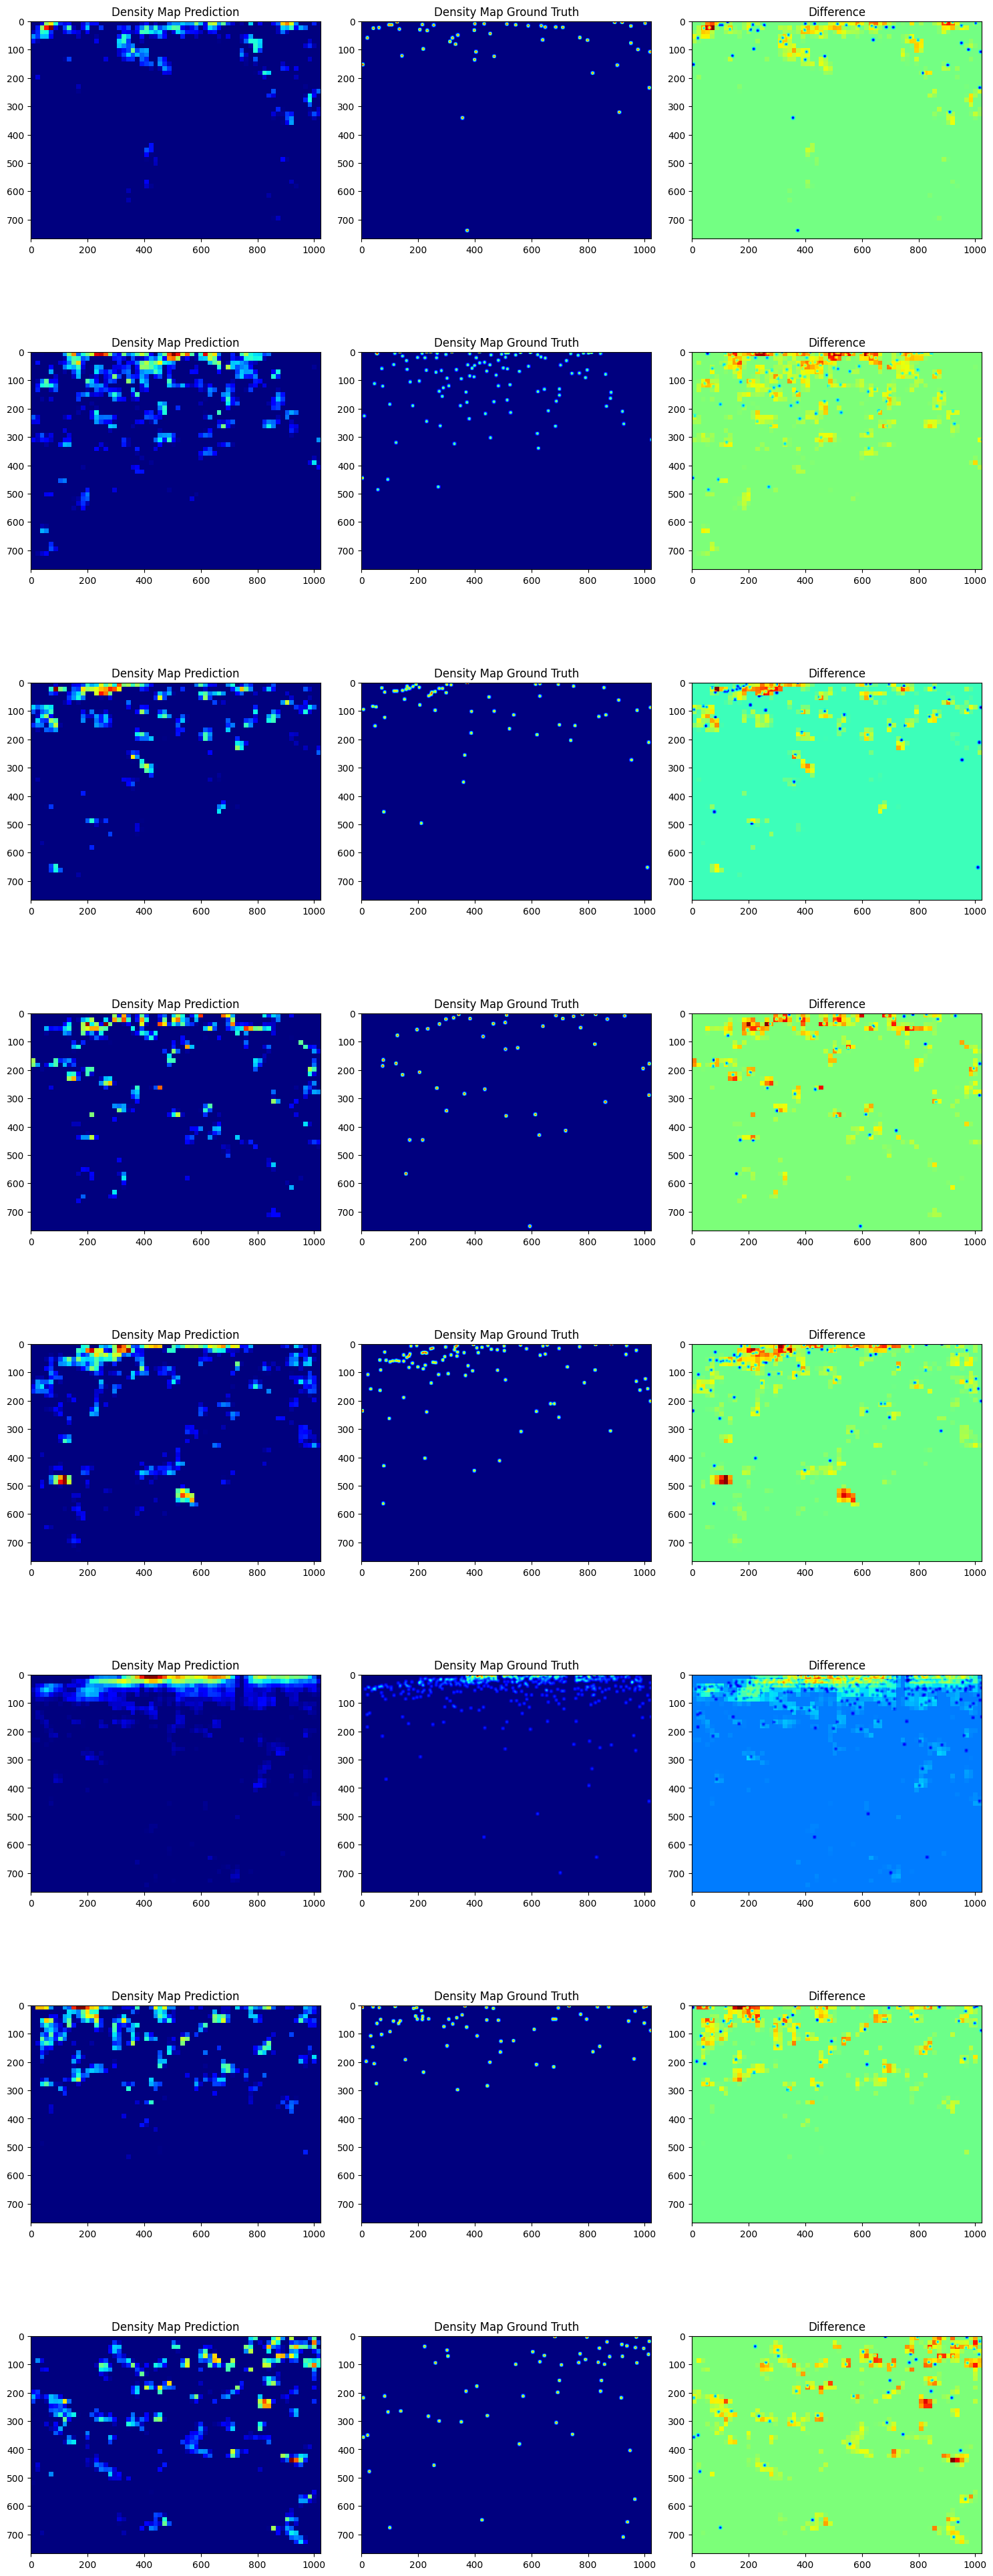

Test RMSE: 31.3666, Test MAE: 19.1266


In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net = AlexNet().to(device)
net.load_state_dict(torch.load(f'{net.__class__.__name__}_best_model.pth'))
test_loader, log_para, restore_transform = get_data_loader('./dataset', batch_size=8, mode='test')
test_rmse, test_mae = test(net, test_loader, device, log_para)
print(f'Test RMSE: {test_rmse:.4f}, Test MAE: {test_mae:.4f}')